## Lymphocyte counts core genes - DE analysis on OneK1K

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
import pertpy
import yaml

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

import process as process
import plot as plot

sys.path.append('../3_DE_analysis')
from DE_analysis_utils import *


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _ARRAY_API not found

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [3]:
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/OneK1K_analysis/'
figdir = 'figures/'
resultsdir = 'results/'
h5ad_file = '/mnt/oak/users/emma/data/cxg_datasets/Yazar2022.h5ad'


### Read perturb-seq results

In [5]:
# Import utility functions from DE_analysis_utils.py
import sys
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [23]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
# get features used on perturb-seq dataset
adata_de_var = adata_de.var.copy()
adata_de_obs = adata_de.obs.copy()

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    
adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'ARHGAP11B', 'LINC02929', 'CDR1', 'PRRC2B', 'F8A1', 'HOMEZ', 'C2orf83',
       'ENSG00000290797', 'ENSG00000291096', 'SOD2'],
      dtype='object', length=13959)

### DE test

In [513]:
datadir = '/mnt/oak/users/emma/data/GWT/OneK1K_analysis/'
ct = 'CD4T'
ct_counts = pd.read_csv(datadir+'cell_type_counts_full.csv', index_col=0)
metadata = pd.read_csv(datadir + f'Yazar2022_{ct}_processed.metadata.csv', index_col=0)
adata_sums = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")

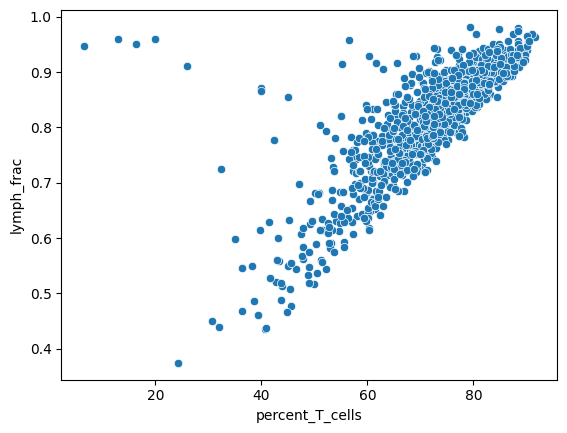

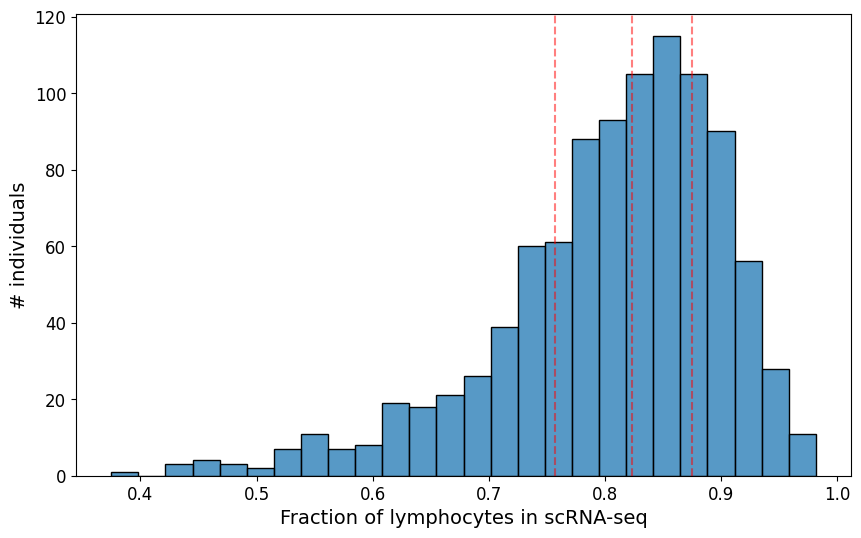

In [589]:
lymphocytes = ['B intermediate', 'B memory', 'B naive', 'CD4 CTL',
       'CD4 Naive', 'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive',
       'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'NK Proliferating',
       'NK_CD56bright', 'Treg', 'gdT', 'dnT']
metadata['lymph_frac'] = ct_counts[lymphocytes].sum(1) / ct_counts.sum(1)
metadata['lymph_frac_quartile'] = pd.qcut(metadata['lymph_frac'], q=4, labels=False) / 3  # Dividing by 3 to get values between 0-1

sns.scatterplot(data=metadata, x='percent_T_cells', y='lymph_frac')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=metadata, x='lymph_frac')
plt.xlabel("Fraction of lymphocytes in scRNA-seq", fontsize=14)
plt.ylabel("# individuals", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
quartiles = metadata['lymph_frac'].quantile([0.25, 0.5, 0.75])
for q in quartiles:
    plt.axvline(x=q, color='red', linestyle='--', alpha=0.5)
plt.show()

In [532]:

cols_to_drop = ['age', 'donor_id', 'predicted.celltype.l2', 'total_counts', 'cell_counts', 
                'avg_count_per_cell', 'log_counts_per_cell', 'split', 'percent_B_cells', 'percent_T_cells', 'lymph_frac']
covars = list(metadata.columns.drop([col for col in cols_to_drop if col in metadata.columns]))
print(covars)

counts = sc.get.obs_df(adata_sums, adata_sums.var_names.tolist())

# Fit DESeq for training and validation sets
train_dds = process.fit_DEseql(metadata, counts, cols=covars)

['male', 'age_cat', 'total_cells', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'lymph_frac_quartile']


Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.59 seconds.

Fitting dispersions...
... done in 2.28 seconds.

Fitting dispersion trend curve...
... done in 0.41 seconds.

Fitting MAP dispersions...


logres_prior=0.6466712803374979, sigma_prior=0.6446094253978488


... done in 2.60 seconds.

Fitting LFCs...
... done in 2.60 seconds.



In [533]:
train_dds.obsm['design_matrix']

,Intercept,male,age_cat,total_cells,PC1,PC2,PC3,PC4,PC5,lymph_frac_quartile
1_1,1.0,0,3,1165,7.552644,-7.492749,-0.373168,-1.088072,-0.646786,0.333333
2_2,1.0,0,2,1205,10.145137,-9.403607,3.116207,-1.430571,-0.716486,1.000000
3_3,1.0,0,2,874,4.723199,-3.024619,-4.848723,-4.588936,1.914421,1.000000
4_4,1.0,0,2,1433,7.725653,-7.475343,-4.298766,-1.646242,2.195459,0.333333
6_6,1.0,0,4,1455,3.295102,-4.644571,-8.790048,-1.820888,-3.217460,0.666667
...,...,...,...,...,...,...,...,...,...,...
1077_1078,1.0,1,3,1105,8.350285,5.979254,4.940271,-3.030385,5.166324,0.000000
1078_1079,1.0,1,3,1234,12.804559,0.388624,-1.033844,3.746736,7.326071,0.333333
1079_1080,1.0,0,4,1302,13.391396,4.831818,2.556197,-0.404670,4.165382,0.333333
1080_1081,1.0,0,4,1464,15.131167,0.523486,7.297058,-0.798902,3.490212,0.000000


Calculating cook's distance...
... done in 0.82 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 2.97 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0 0 0 0 0 0 0 0 0 1]
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000243485     0.000000             NaN       NaN       NaN       NaN   
ENSG00000237613     0.000000             NaN       NaN       NaN       NaN   
ENSG00000186092     0.000000             NaN       NaN       NaN       NaN   
ENSG00000238009     0.328157       -0.078983  0.244425 -0.323139  0.746590   
ENSG00000239945     0.010449       -0.292867  2.402748 -0.121888  0.902987   
...                      ...             ...       ...       ...       ...   
ENSG00000212907   162.287442        0.037456  0.030295  1.236346  0.216330   
ENSG00000198886  3959.535602        0.012504  0.018412  0.679153  0.497041   
ENSG00000198786  1079.683487        0.021633  0.026553  0.814718  0.415234   
ENSG00000198695    50.938230        0.056935  0.030455  1.869488  0.061555   
ENSG00000198727  3688.698314       -0.004672  0.022217 -0.210306 

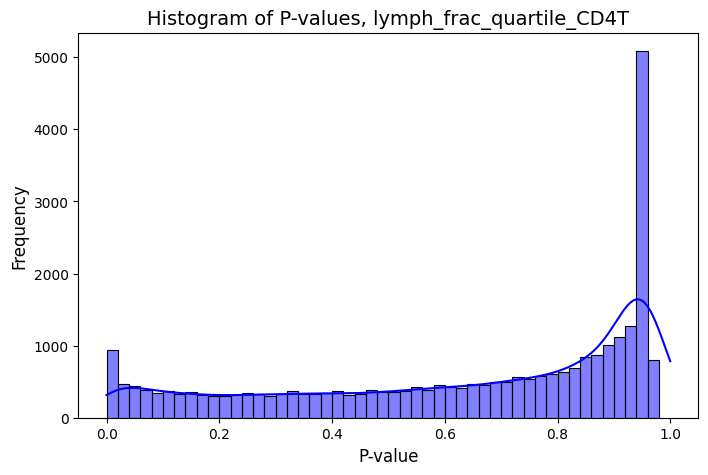

In [534]:
from pydeseq2.ds import DeseqStats
def run_deseq_analysis(dds, covar, output_suffix, figdir, resultsdir):
    contrast = np.zeros(len(dds.obsm['design_matrix'].columns), dtype=int)
    contrast[np.where(dds.obsm['design_matrix'].columns == covar)[0][0]] = 1

    dds.refit()
    ds = DeseqStats(
        dds,
        contrast=contrast,
        alpha=0.05,
        cooks_filter=True,
        independent_filter=True,
    )
    ds.run_wald_test()
    if ds.cooks_filter:
        ds._cooks_filtering()
    
    if ds.independent_filter:
        ds._independent_filtering()
    else:
        ds._p_value_adjustment()
    
    ds.summary()
    ds.results_df.to_csv(resultsdir+'DE_'+covar+f'_{output_suffix}.csv')
    results_df = ds.results_df

    pvalues = results_df["pvalue"].dropna()
    plot.plot_pval_distribution(pvalues, covar+f'_{output_suffix}', figdir)
    
    return results_df

res_df = run_deseq_analysis(train_dds, 'lymph_frac_quartile', f'{ct}', figdir, resultsdir)

### Read DE analysis results

In [535]:
datadir = '/mnt/oak/users/emma/data/GWT/OneK1K_analysis/'
figdir = 'figures/'
resultsdir = 'results/'

NaNs encountered, dropping rows with NaNs


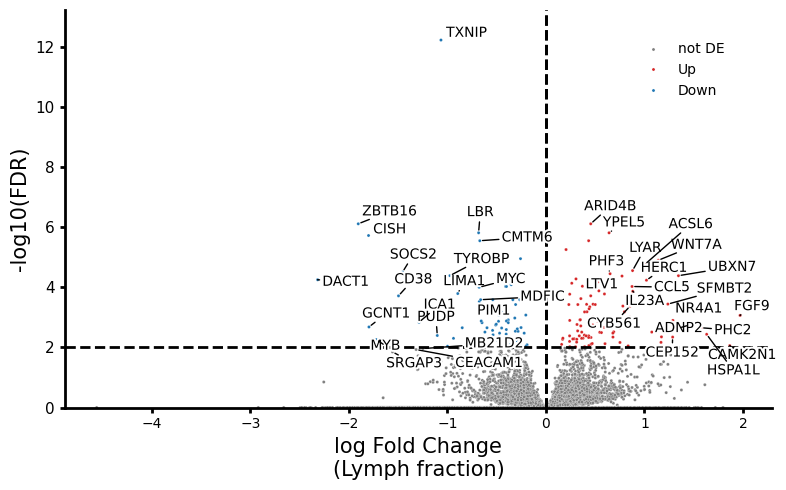

<Figure size 800x2000 with 0 Axes>

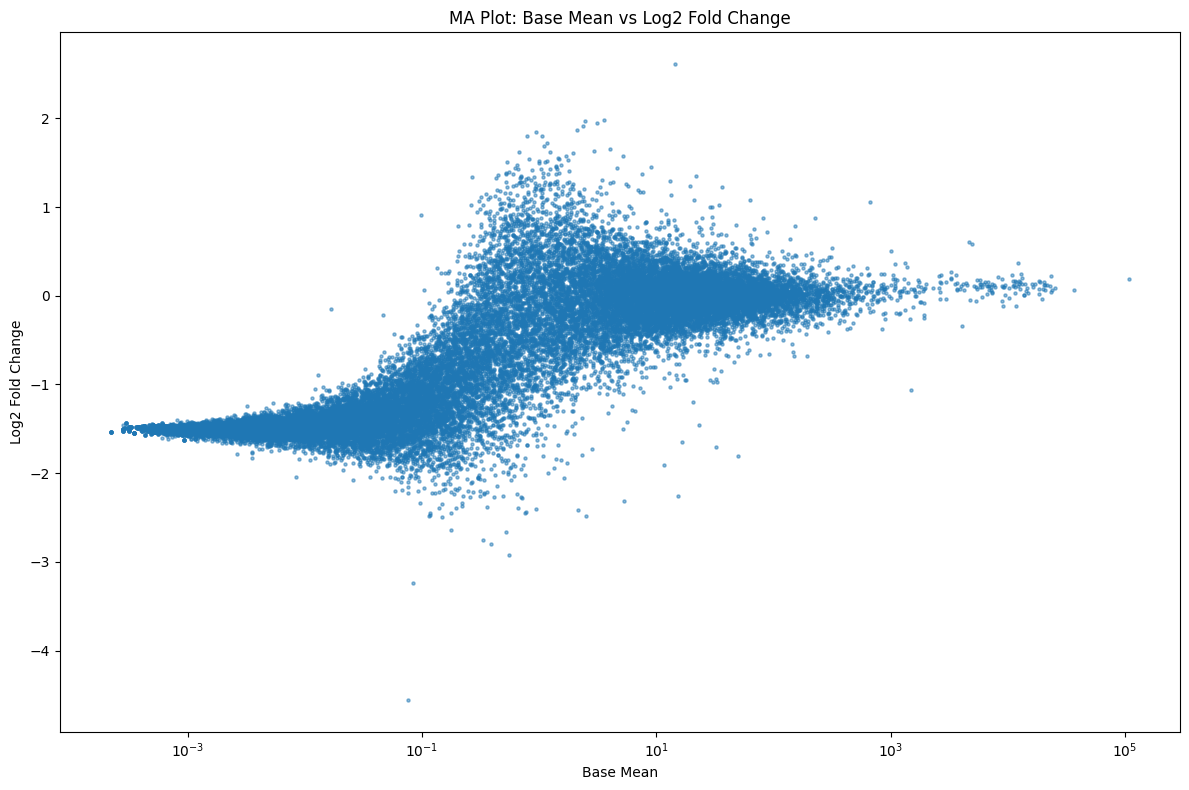

In [590]:


ct = 'CD4T'
pbulk_adata = sc.read_h5ad(datadir + f"Yazar2022_{ct}_processed.pbulk.h5ad")
pbulk_adata.var_names.isin(adata_de_var.index).sum()

res_df = pd.read_csv(f'results/DE_lymph_frac_{ct}.csv', index_col=0)
res_df = res_df.rename({'log2FoldChange':'log_fc', 'padj':'adj_p_value', 'ensembl_id':'variable'}, axis=1)
if 'variable' not in res_df.columns:
    res_df['variable'] = res_df.index.values
res_df['gene_name'] = pbulk_adata.var.loc[res_df.variable]['feature_name'].values
res_df['perturbseq_gene'] = res_df['variable'].isin(adata_de_var.index)
res_df['contrast'] = 'percent_T'
res_df['zscore'] = res_df['log_fc']/res_df['lfcSE']
res_df['adj_p_value'] = res_df['adj_p_value'].fillna(1)

onek1k_design = f"~ male + age_cat"
model = pertpy.tl.PyDESeq2(pbulk_adata, design=onek1k_design)

fig = model.plot_volcano(
    res_df[res_df['perturbseq_gene']], 
    log2fc_thresh=0, 
    return_fig=True, 
    to_label = 20,
    symbol_col='gene_name',
    figsize=(8, 5),  # Increased figure size
    s=5,
    pval_thresh=0.01,
    legend_pos = (0.95,0.95),
    y_label = '-log10(FDR)',
    x_label = 'log Fold Change\n(Lymph fraction)'
    )
fig.tight_layout()  
fig.show()  

plt.figure(figsize=(8,20))
fig = plt.figure(figsize=(12, 8))
plt.scatter(res_df['baseMean'], res_df['log_fc'], alpha=0.5, s=5)
plt.xscale('log')
plt.xlabel('Base Mean')
plt.ylabel('Log2 Fold Change') 
plt.title('MA Plot: Base Mean vs Log2 Fold Change')
fig.tight_layout()
plt.show()

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:827: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['1_1', '2_2', '3_3', '4_4', '6_6']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/_core/anndata.py:850: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


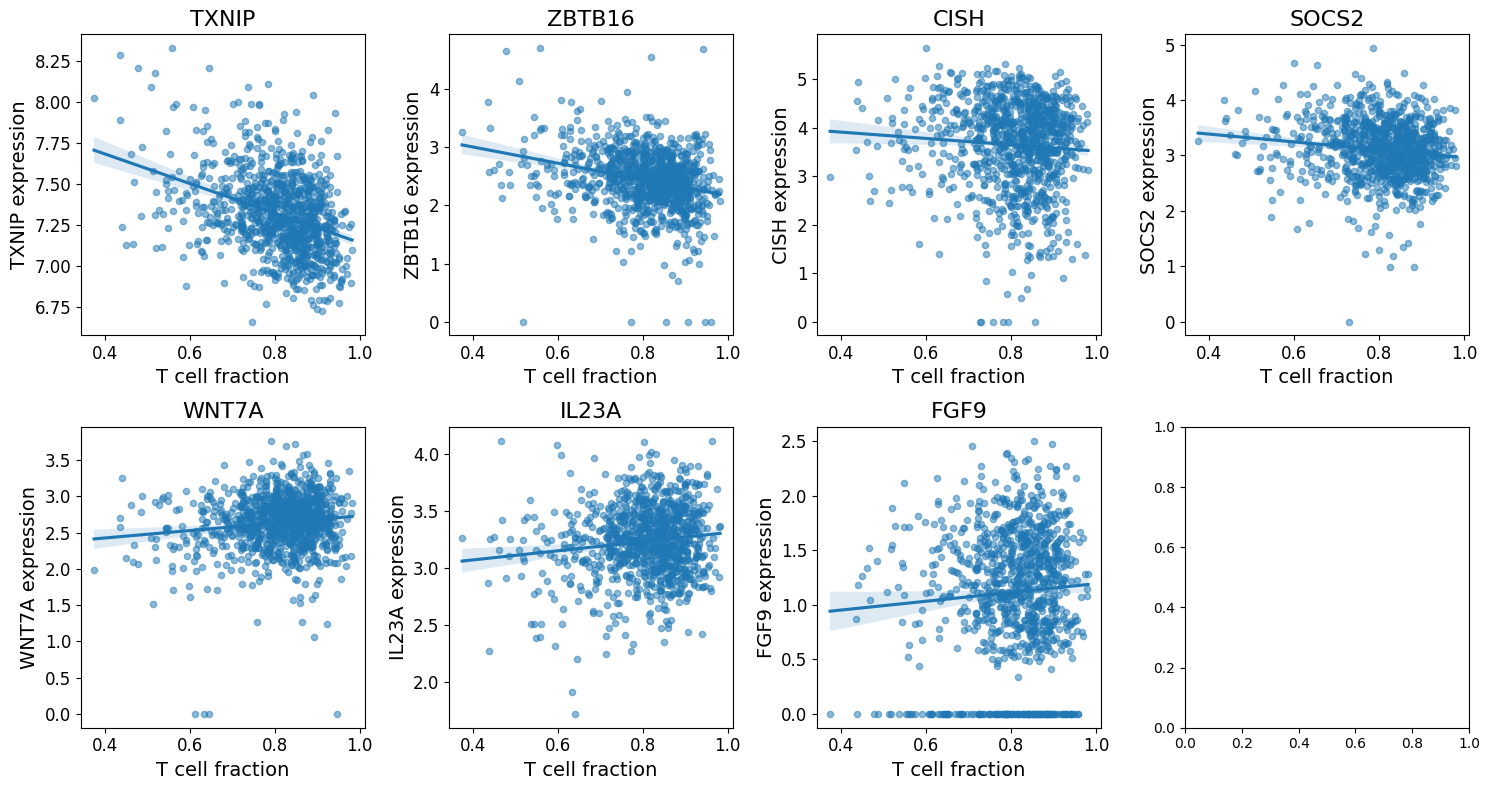

In [578]:
pbulk_adata.obs_names_make_unique()
pbulk_adata.var['ensembl_id'] = pbulk_adata.var.index
pbulk_adata.var_names = pbulk_adata.var['feature_name']

pbulk_adata.obs['lymph_frac'] = metadata.loc[pbulk_adata.obs_names]['lymph_frac']

gs = [
    'TXNIP', 'ZBTB16', 'CISH','SOCS2', 
    'WNT7A', 'IL23A', 'FGF9']
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for i, g in enumerate(gs):
    gex_df = sc.get.obs_df(pbulk_adata, [g, 'lymph_frac'], layer='log1p_norm')
    sns.regplot(data=gex_df, x='lymph_frac', y=g, ax=axes[i], scatter_kws={'alpha':0.5, 's':20})
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].set_xlabel('T cell fraction', fontsize=14)
    axes[i].set_ylabel(f'{g} expression', fontsize=14)
    axes[i].set_title(g, fontsize=16)
plt.tight_layout()

In [579]:
lof_burden_test = pd.read_table('/mnt/oak/users/mineto/workstation/250717_TcellPerturb/input/burden/Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv')
print(lof_burden_test.head())

lof_results = pd.read_table('/mnt/oak/users/mineto/workstation/250717_TcellPerturb/BurdenRegCor/GeneLevel/Stim48hr_Backman_LymphocyteCount_fullFeatures.per_gene_estimates.tsv_geneRegulation_correlation.txt')
print(lof_results.head())

              ensg    param0    param1     param2  prior_mean  post_mean  \
0  ENSG00000131737 -1.350462  1.350852  40.602400   -0.019331  -0.018514   
1  ENSG00000107779  1.281669  1.102944  48.588310    0.013050   0.010721   
2  ENSG00000168016  0.678739  0.839311  82.535426    0.003292   0.003303   
3  ENSG00000187566  1.119358  1.048689  51.739416    0.010007   0.021401   
4  ENSG00000109436  2.118582  1.819757  48.637223    0.029260   0.021643   

   lower_95  upper_95  
0 -0.071022  0.036229  
1 -0.036708  0.056498  
2 -0.015002  0.022504  
3 -0.014843  0.073735  
4 -0.034474  0.067192  
       gene             ensg  P_withShet  beta_withShet  betaSE_withShet  \
0    TSPAN6  ENSG00000000003    0.986855       0.000158         0.009610   
1      DPM1  ENSG00000000419    0.006943      -0.025945         0.009609   
2     SCYL3  ENSG00000000457    0.463538       0.007044         0.009609   
3  C1orf112  ENSG00000000460    0.593118      -0.005135         0.009609   
4       FGR  ENSG00

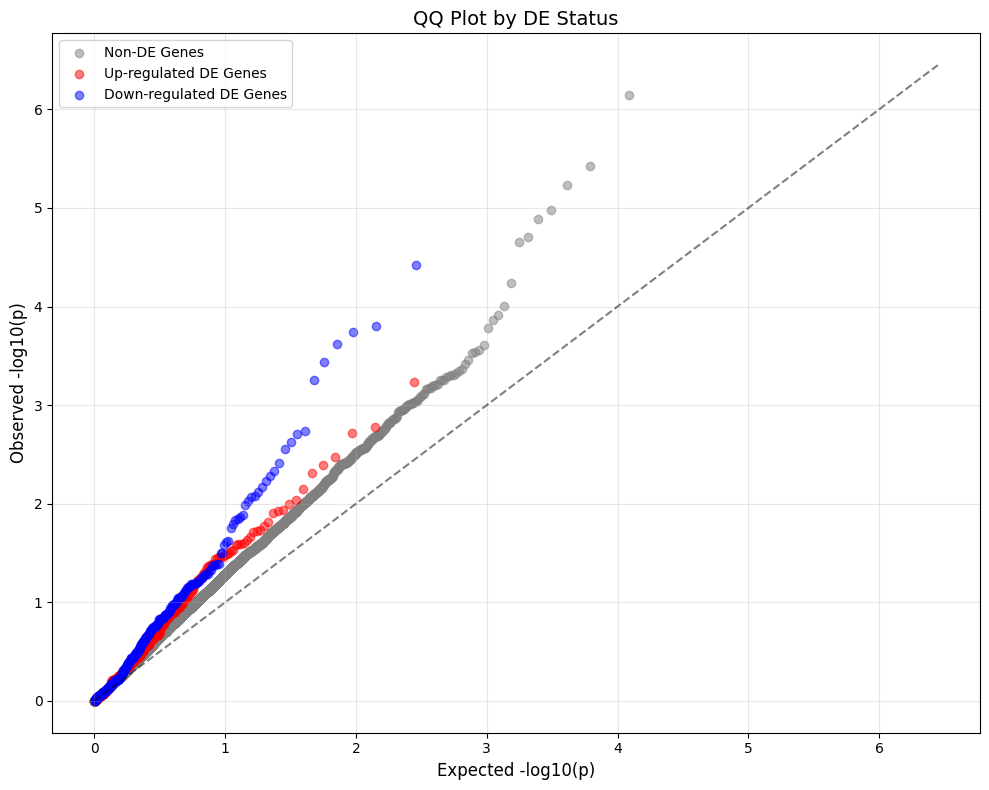

In [580]:
# Get DE genes
up_de = res_df[(res_df['adj_p_value'] < threshold) & (res_df['log_fc'] > 0)]['gene_name'].tolist()
down_de = res_df[(res_df['adj_p_value'] < threshold) & (res_df['log_fc'] < 0)]['gene_name'].tolist()
lof_results['up_DE'] = lof_results['gene'].isin(up_de)
lof_results['down_DE'] = lof_results['gene'].isin(down_de)

# Create separate dataframes for each group
up_de_df = lof_results[lof_results['up_DE']]
down_de_df = lof_results[lof_results['down_DE']] 
non_de_df = lof_results[~(lof_results['up_DE'] | lof_results['down_DE'])]

# Create single QQ plot with all groups
plt.figure(figsize=(10, 8))

# Plot each group with different colors
for df, label, color in [(non_de_df, 'Non-DE Genes', 'gray'), 
                        (up_de_df, 'Up-regulated DE Genes', 'red'),
                        (down_de_df, 'Down-regulated DE Genes', 'blue')]:
    
    observed_p = -np.log10(np.sort(df['P_withShet']))
    expected_p = -np.log10(np.arange(1, len(observed_p) + 1) / (len(observed_p) + 1))
    plt.scatter(expected_p, observed_p, alpha=0.5, label=label, color=color)

# Add diagonal reference line
max_val = max(plt.xlim()[1], plt.ylim()[1])
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('Expected -log10(p)', fontsize=12)
plt.ylabel('Observed -log10(p)', fontsize=12)
plt.title('QQ Plot by DE Status', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [581]:
import statsmodels
def pvalue_from_beta_ci(beta, ci_lower, ci_upper, null_value=0):
    """
    Calculate p-value from beta coefficient and 95% confidence interval.
    
    Parameters:
    -----------
    beta : float
        The estimated coefficient (point estimate)
    ci_lower : float
        Lower bound of 95% confidence interval
    ci_upper : float
        Upper bound of 95% confidence interval
    null_value : float, default=0
        Null hypothesis value to test against
        
    Returns:
    --------
    dict : Dictionary containing p-value and related statistics
    """
    
    # Calculate standard error from CI
    # For 95% CI: CI = beta ± 1.96 * SE (for large samples)
    # So: SE = (ci_upper - ci_lower) / (2 * 1.96)
    se = (ci_upper - ci_lower) / (2 * 1.96)
    
    # Calculate t-statistic
    t_stat = (beta - null_value) / se
    
    # For large samples, use normal distribution (z-test)
    # P-value for two-tailed test
    p_value_normal = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    return p_value_normal

# Calculate p-values for each gene
lof_burden_test['pvalue'] = lof_burden_test.apply(
    lambda x: pvalue_from_beta_ci(
        x['post_mean'],
        x['lower_95'],
        x['upper_95']
    ),
    axis=1
)

# Apply Benjamini-Hochberg FDR correction
lof_burden_test['padj'] = statsmodels.stats.multitest.fdrcorrection(lof_burden_test['pvalue'], alpha=0.05, method='indep')[1]
sum(lof_burden_test['padj'] < 0.1)

371

In [582]:
# lof_results_signif = lof_results[['ensg', 'P_pearson', 'R_pearson']]
# lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.01) & (np.abs(lof_results_signif['R_pearson']) > 0.1)
# lof_results_signif['abs_R_pearson'] = lof_results_signif['R_pearson'].abs()

In [583]:
def get_odds_ratio(contingency):
    '''
    Odds ratio 
    '''
    # Perform Fisher's exact test to assess significance and get confidence intervals
    from scipy.stats import fisher_exact
    import numpy as np

    odds_ratio, pvalue = fisher_exact(contingency)

    # Calculate 95% confidence intervals for odds ratio
    # Using formula from Woolf's method
    a = contingency.loc[True, True]
    b = contingency.loc[True, False] 
    c = contingency.loc[False, True]
    d = contingency.loc[False, False]

    se = np.sqrt(1/a + 1/b + 1/c + 1/d)
    ci_lower = np.exp(np.log(odds_ratio) - 1.96*se)
    ci_upper = np.exp(np.log(odds_ratio) + 1.96*se)

    print(f"\nOdds ratio: {odds_ratio:.2f} (95% CI: {ci_lower:.2f}-{ci_upper:.2f})")
    print(f"P-value: {pvalue:.2e}")
    return odds_ratio, pvalue, ci_lower, ci_upper


Contingency table for all DE genes:
DE_signif_all  True   False
LoF_signif                 
True              77   1154
False            608  27146

Odds ratio: 2.98 (95% CI: 2.33-3.80)
P-value: 8.11e-15

Contingency table for up DE genes:
DE_signif_up  True   False
LoF_signif                
True             39   1192
False           301  27453

Odds ratio: 2.98 (95% CI: 2.13-4.19)
P-value: 2.08e-08

Contingency table for down DE genes:
DE_signif_down  True   False
LoF_signif                  
True               38   1193
False             307  27447

Odds ratio: 2.85 (95% CI: 2.02-4.01)
P-value: 9.20e-08


/tmp/ipykernel_1829785/3616544606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05)


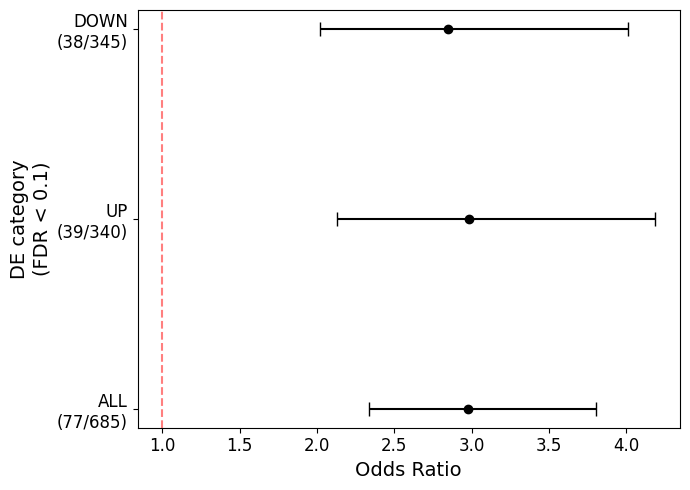

In [584]:
# Create binary indicators for significance at threshold 0.1
de_results_signif = res_df.dropna().rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value', 'log_fc']]
lof_results_signif = lof_results[['ensg', 'P_withShet', 'beta_withShet']]
lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05)

# Create indicators for different DE categories
de_results_signif['DE_signif_all'] = (de_results_signif['adj_p_value'] < 0.1)
de_results_signif['DE_signif_up'] = (de_results_signif['adj_p_value'] < 0.1) & (de_results_signif['log_fc'] > 0)
de_results_signif['DE_signif_down'] = (de_results_signif['adj_p_value'] < 0.1) & (de_results_signif['log_fc'] < 0)

results = []
categories = ['all', 'up', 'down']

for category in categories:
    # Merge dataframes
    merged_df = pd.merge(de_results_signif[['ensg', f'DE_signif_{category}']], 
                        lof_results_signif[['ensg', 'LoF_signif']], 
                        on='ensg', how='left').fillna(False)
    
    # Create contingency table
    contingency = pd.crosstab(merged_df['LoF_signif'], merged_df[f'DE_signif_{category}']).iloc[[1,0], [1,0]]
    print(f"\nContingency table for {category} DE genes:")
    print(contingency)
    
    # Calculate odds ratio and stats
    odds_ratio, pvalue, ci_lower, ci_upper = get_odds_ratio(contingency)
    
    # Store results
    results.append({
        'category': category,
        'odds_ratio': odds_ratio,
        'pvalue': pvalue,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_de_signif_lof': (merged_df[f'DE_signif_{category}'] & merged_df['LoF_signif']).sum(),
        'n_de_signif': merged_df[f'DE_signif_{category}'].sum(),
        'n_total': len(merged_df)
    })

# Create results dataframe
results_df = pd.DataFrame(results)

# Plot odds ratios for different categories
plt.figure(figsize=(7,5))
plt.errorbar(results_df['odds_ratio'], range(len(results_df)),
             xerr=[results_df['odds_ratio'] - results_df['ci_lower'],
                   results_df['ci_upper'] - results_df['odds_ratio']],
             fmt='o', capsize=5, color='black')
plt.axvline(x=1, color='red', linestyle='--', alpha=0.5)
plt.yticks(range(len(results_df)), [f"{cat.upper()}\n({n}/{tot})" for cat,n,tot in 
           zip(results_df['category'], results_df['n_de_signif_lof'], results_df['n_de_signif'])], fontsize=12)
plt.ylabel('DE category\n(FDR < 0.1)', fontsize=14)
plt.xlabel('Odds Ratio', fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1829785/830976625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05) #& (lof_results_signif['beta_withShet'] < 0)


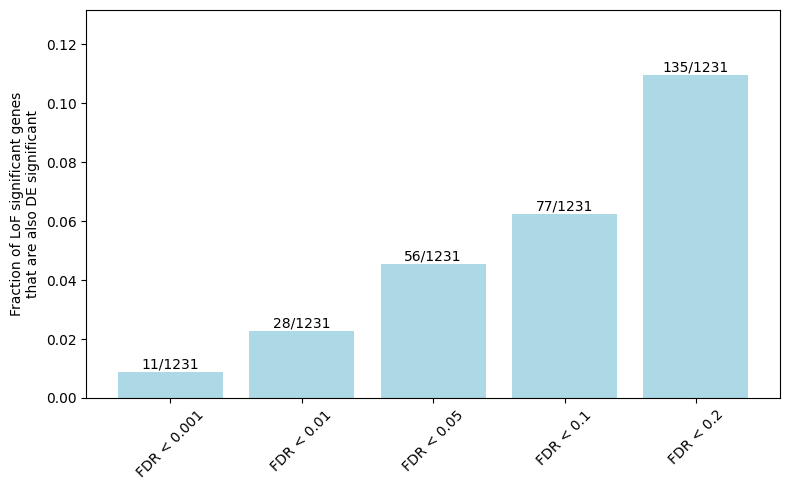

In [585]:
# Create binary indicators for significance at different thresholds
de_results_signif = res_df.dropna().rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value', 'log_fc']]
lof_results_signif = lof_results[['ensg', 'P_withShet', 'beta_withShet']]
lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05) #& (lof_results_signif['beta_withShet'] < 0)

# Calculate fraction of LoF significant genes that are also DE significant at different thresholds
thresholds = [0.001, 0.01, 0.05, 0.1, 0.2]
fractions = []
de_counts = []
total_lof_counts = []

for threshold in thresholds:
    de_results_signif[f'DE_signif_{threshold}'] = (de_results_signif['adj_p_value'] < threshold)
    merged = pd.merge(de_results_signif[['ensg', f'DE_signif_{threshold}']], 
                     lof_results_signif[['ensg', 'LoF_signif']], 
                     on='ensg', how='left').fillna(False)
    merged = merged[merged['LoF_signif']]
    
    total_lof = merged['LoF_signif'].sum()
    de_and_lof = merged[f'DE_signif_{threshold}'].sum()
    
    fractions.append(de_and_lof / total_lof)
    de_counts.append(de_and_lof)
    total_lof_counts.append(total_lof)

# Create bar plot
plt.figure(figsize=(8,5))
plt.bar([f'FDR < {t}' for t in thresholds], fractions, color='lightblue')
plt.ylabel('Fraction of LoF significant genes\nthat are also DE significant')
plt.xticks(rotation=45)

# Add count labels on top of bars
for i, (de, total) in enumerate(zip(de_counts, total_lof_counts)):
    plt.text(i, fractions[i], f'{de}/{total}', 
             horizontalalignment='center',
             verticalalignment='bottom')

plt.ylim(0, max(fractions) * 1.2)  # Add some space for labels
plt.tight_layout()
plt.show()


/tmp/ipykernel_1829785/3462881544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05)  #& (lof_results_signif['beta_withShet'] > 0)


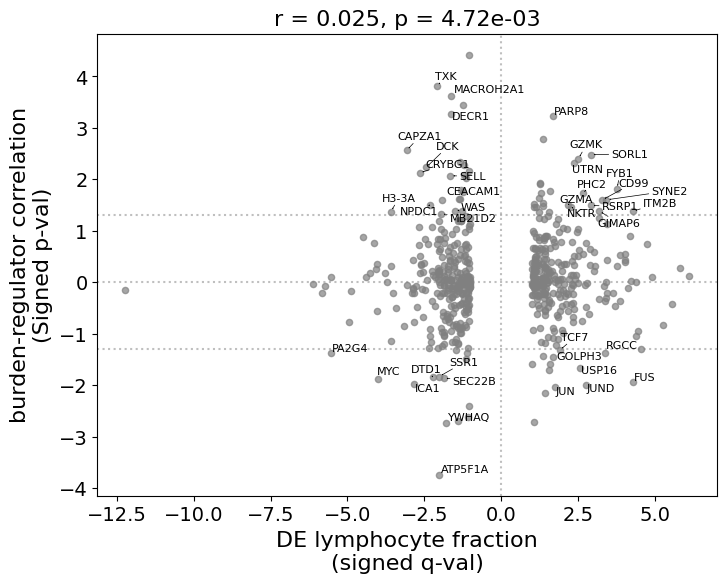

In [587]:
# Merge DE and LoF results
de_results_signif = res_df.dropna().rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value', 'log_fc', 'gene_name']]
lof_results_signif = lof_results[['ensg', 'P_withShet', 'beta_withShet']]
lof_results_signif['LoF_signif'] = (lof_results_signif['P_withShet'] < 0.05)  #& (lof_results_signif['beta_withShet'] > 0)

merged_df = pd.merge(de_results_signif[['ensg', 'log_fc', 'adj_p_value', 'gene_name']], 
                    lof_results_signif[['ensg', 'P_withShet', 'beta_withShet', 'LoF_signif']], 
                    on='ensg', how='inner')
merged_df['signed_P_withShet'] = -np.log10(merged_df['P_withShet']) * np.sign(merged_df['beta_withShet'])
merged_df['signed_DE_padj'] = -np.log10(merged_df['adj_p_value']) * np.sign(merged_df['log_fc'])
# merged_df = merged_df[merged_df['LoF_signif']]

# Calculate correlation coefficient and p-value
from scipy import stats
r, p = stats.spearmanr(merged_df['signed_DE_padj'], merged_df['signed_P_withShet'])

# Create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(data=merged_df[merged_df['adj_p_value'] < 0.1], 
           x='signed_DE_padj', y='signed_P_withShet',
           s=20, c='grey', alpha=0.7)

# Add horizontal dotted lines at y=0, 1, and -1
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=np.log10(0.05), color='gray', linestyle=':', alpha=0.5)

# Label top and bottom 10 LoF significant genes by DE effect size
lof_genes = merged_df[(merged_df['adj_p_value'] < 0.1) & (merged_df['LoF_signif'])]
top_n = lof_genes.nlargest(20, 'signed_DE_padj')
bottom_n = lof_genes.nsmallest(20, 'signed_DE_padj') 
lof_genes = pd.concat([top_n, bottom_n])

# Add gene labels with adjustText to avoid overlap
from adjustText import adjust_text

texts = []
for _, gene in lof_genes.iterrows():
    texts.append(plt.text(gene['signed_DE_padj'], gene['signed_P_withShet'], 
                         gene['gene_name'], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xlabel('DE lymphocyte fraction\n(signed q-val)', fontsize=16)
plt.ylabel('burden-regulator correlation\n(Signed p-val)', fontsize=16)
plt.title(f'r = {r:.3f}, p = {p:.2e}', fontsize=16);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

In [591]:
import gseapy as gp

def parse_gene_sets(filename):
   gene_sets = {}
   with open(filename, 'r') as f:
       for line in f:
           terms = line.strip().split('\t')
           gene_sets[terms[0]] = terms[2:]
   return gene_sets

# Parse and merge both gene set dictionaries
OAKPATH = '/mnt/oak/'
KEGG_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data//KEGG_2019_Human.txt')
GO_BP_sets = parse_gene_sets(f'{OAKPATH}/users/emma/data/GO_Biological_Process_2023.txt')
GENESETS = {**KEGG_sets, **GO_BP_sets}

background = merged_df.gene_name.tolist()
test_genes = merged_df[(merged_df['adj_p_value'] < 0.1) & (merged_df['LoF_signif'])].gene_name.tolist()

enr = gp.enrichr(gene_list=test_genes,
                    gene_sets=GENESETS,
                    organism='Human', 
                    background=background,
                    outdir='results/test_enrichr/',
                    no_plot=True
                    )
enr.results.sort_values('Adjusted P-value')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
520,gs_ind_0,Positive Regulation Of Myeloid Leukocyte Media...,1/10,0.059616,0.216033,25.767802,72.660670,ITGB2
270,gs_ind_0,Negative Regulation Of Catalytic Activity (GO:...,2/19,0.005920,0.216033,23.607379,121.091253,GZMA;CLN3
689,gs_ind_0,Regulation Of Collagen Biosynthetic Process (G...,2/12,0.002349,0.216033,39.367707,238.318210,RGCC;VIM
863,gs_ind_0,Response To Catecholamine (GO:0071869),1/3,0.018266,0.216033,97.972549,392.155062,GNG2
856,gs_ind_0,Regulation Of miRNA Transcription (GO:1902893),2/50,0.037548,0.216033,8.496962,27.888275,MYC;JUN
...,...,...,...,...,...,...,...,...
115,gs_ind_0,DNA Repair (GO:0006281),1/258,0.798461,0.801855,0.931772,0.209713,MACROH2A1
588,gs_ind_0,Protein Localization (GO:0008104),1/281,0.825564,0.828193,0.853763,0.163657,SNX6
926,gs_ind_0,Vesicle-Mediated Transport (GO:0016192),1/333,0.874283,0.876138,0.717175,0.096353,VAMP8
600,gs_ind_0,Protein Modification Process (GO:0036211),2/588,0.881299,0.882233,0.672273,0.084947,SNRK;TXK


In [592]:
LC_regulators = lof_burden_test[lof_burden_test.padj < 0.1].ensg.tolist()

threshold = 0.1
de_results_signif[f'DE_signif'] = (de_results_signif['adj_p_value'] < threshold) #& (de_results_signif['log_fc'] < 0)

# Merge dataframes
merged_df = pd.merge(de_results_signif[['ensg', f'DE_signif']], 
                    lof_results_signif[['ensg', 'LoF_signif']], 
                    on='ensg', how='left').fillna(False)

DE_core_genes = merged_df[merged_df['DE_signif'] & merged_df['LoF_signif']].ensg.tolist()
len(DE_core_genes)

77

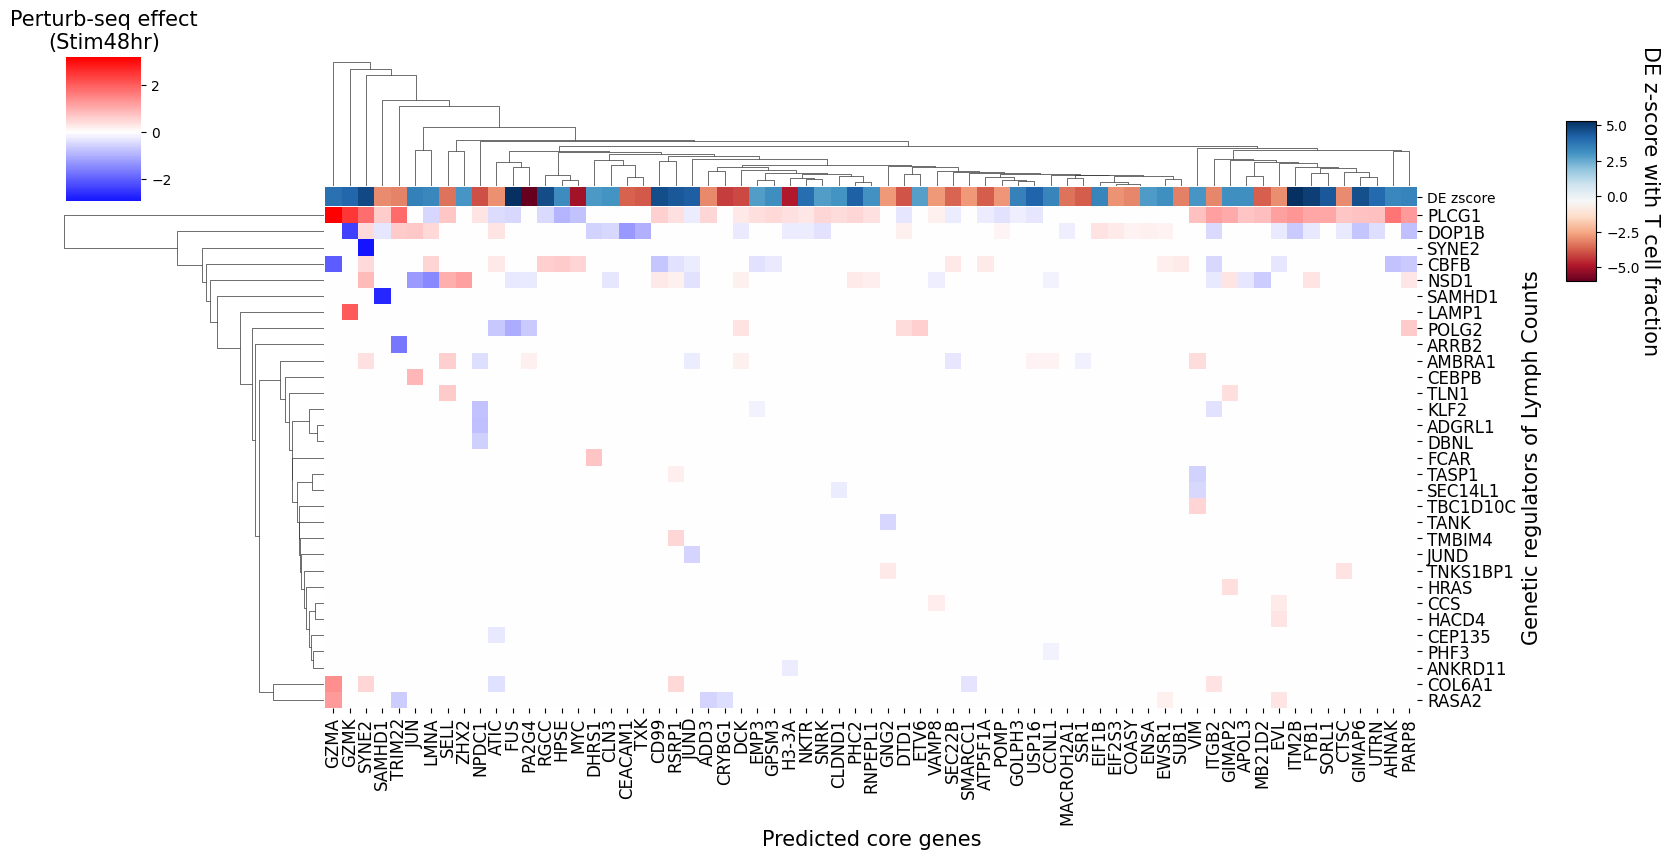

In [594]:
DE_effects = get_DE_results_long(adata_de, genes=DE_core_genes, targets = LC_regulators, gene_id_col='gene_ids', target_id_col='target_contrast', target_metadata_cols=['target_contrast_gene_name', 'culture_condition'])
DE_effects = DE_effects[(DE_effects['culture_condition'] == 'Stim48hr') & (DE_effects['significant'])]
# DE_effects = pd.merge(DE_effects,lof_burden_test.rename({'ensg':'target_contrast'}, axis=1)[['target_contrast', 'post_mean']], how='left')
DE_frac_zscore = res_df.set_index('gene_name').loc[pl_df.index]['zscore']
# DE_effects = pd.merge(DE_effects, DE_frac_zscore.reset_index().rename({'index':'gene'}), on='gene')
# DE_effects[DE_effects['gene'] == 'ICA1'].sort_values('adj_p_value')

# order_core_gs = DE_effects.sort_values('zscore_y')['gene'].unique()
# order_regs = DE_effects.sort_values('post_mean')['target_contrast_gene_name'].unique()

pl_df = DE_effects.pivot(index='gene', columns='target_contrast_gene_name', values='log_fc').fillna(0)
DE_frac_zscore = res_df.set_index('gene_name').loc[pl_df.index]['zscore']
# Create row colors annotation for DE zscore by mapping to RGB scale
min_val = DE_frac_zscore.min()
max_val = DE_frac_zscore.max()
norm = plt.Normalize(min_val, max_val)
cmap = plt.cm.RdBu # Red-White-Blue colormap
rgb_colors = cmap(norm(DE_frac_zscore))
row_colors = pd.Series(rgb_colors[:,0], index=DE_frac_zscore.index, name='DE effect with T cell fraction (OneK1K)')

# Convert row_colors to list of RGB tuples
row_colors_list = [tuple(color) for color in rgb_colors]
row_colors = pd.Series(row_colors_list, index=DE_frac_zscore.index, name='DE zscore')

# Create clustermap with swapped axes and all gene names shown
g = sns.clustermap(pl_df.T, cmap='bwr', center=0,
                   col_colors=row_colors, 
                   figsize=(15,8),
                   xticklabels=True, 
                   yticklabels=True,
                   )
g.ax_heatmap.set_xlabel('Predicted core genes', fontsize=15)
g.ax_heatmap.set_ylabel('Genetic regulators of Lymph Counts', fontsize=15)
g.ax_cbar.set_title('Perturb-seq effect\n(Stim48hr)', fontsize=15)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='center', fontsize=12) # Rotate x labels for better readability
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=12)

# Add legend for color bar
norm = plt.Normalize(DE_frac_zscore.min(), DE_frac_zscore.max())
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
cax = g.fig.add_axes([1.02, 0.7, 0.02, 0.2])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('DE z-score with T cell fraction', rotation=270, labelpad=15, fontsize=15)



<Axes: xlabel='target_contrast_gene_name', ylabel='gene'>

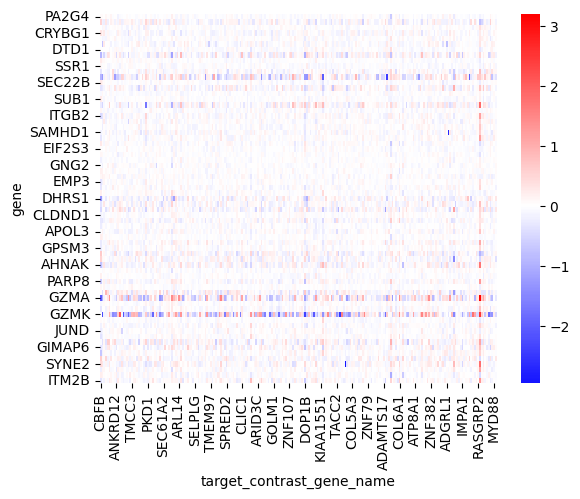

In [426]:
DE_effects = get_DE_results_long(adata_de, genes=DE_core_genes, targets = LC_regulators, gene_id_col='gene_ids', target_id_col='target_contrast', target_metadata_cols=['target_contrast_gene_name', 'culture_condition'])
DE_effects = DE_effects[(DE_effects['culture_condition'] == 'Stim48hr')]
DE_effects = pd.merge(DE_effects,lof_burden_test.rename({'ensg':'target_contrast'}, axis=1)[['target_contrast', 'post_mean']], how='left')
DE_frac_zscore = res_df.set_index('gene_name').loc[pl_df.index]['zscore']
DE_effects = pd.merge(DE_effects, DE_frac_zscore.reset_index().rename({'index':'gene'}), on='gene')
# DE_effects[DE_effects['gene'] == 'ICA1'].sort_values('adj_p_value')

order_core_gs = DE_effects.sort_values('zscore_y')['gene'].unique()
order_regs = DE_effects.sort_values('post_mean')['target_contrast_gene_name'].unique()

pl_df = DE_effects.pivot(index='gene', columns='target_contrast_gene_name', values='log_fc').fillna(0)

sns.heatmap(pl_df.loc[order_core_gs, order_regs], cmap='bwr', center=0)

/tmp/ipykernel_1829785/3381776436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_effect['DE_direction'] = np.sign(reg_effect['zscore_y'])


3.0

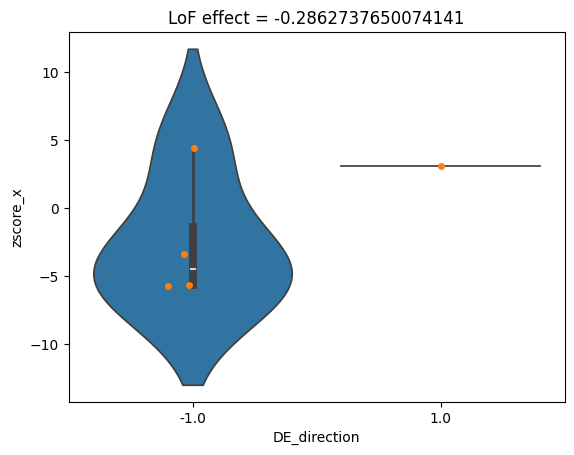

In [207]:
DE_effects_merged = pd.merge(DE_effects, DE_frac_zscore.reset_index().rename({'index':'gene'}), on='gene')

reg_effect = DE_effects_merged[DE_effects_merged['target_contrast_gene_name'] == 'RASA2']
reg_effect['DE_direction'] = np.sign(reg_effect['zscore_y'])

sns.violinplot(data=reg_effect, x='DE_direction', y='zscore_x');
sns.stripplot(data=reg_effect, x='DE_direction', y='zscore_x');
plt.title(f"LoF effect = {reg_effect['post_mean'].unique()[0]}")

# reg_effect['post_mean'].iloc[0] sum( np.sign(reg_effect['zscore_x']) * np.sign(reg_effect['zscore_y']))

In [211]:
DE_effects_merged['zscore_x']

,index,gene,log_fc,zscore_x,adj_p_value,significant,gene_ids,target_contrast_gene_name,culture_condition,target_contrast,post_mean,zscore_y
0,ENSG00000054654_Stim48hr,SYNE2,-2.945866,-15.644508,4.589645e-51,True,ENSG00000054654,SYNE2,Stim48hr,ENSG00000054654,-0.051539,5.134708
1,ENSG00000067955_Stim48hr,CD99,-0.704350,-5.026232,8.017527e-05,True,ENSG00000002586,CBFB,Stim48hr,ENSG00000067955,-0.550790,4.870595
2,ENSG00000067955_Stim48hr,CLASP1,-0.469097,-2.816446,5.117890e-02,True,ENSG00000074054,CBFB,Stim48hr,ENSG00000067955,-0.550790,3.023223
3,ENSG00000067955_Stim48hr,CYRIB,-0.240271,-3.033360,3.323530e-02,True,ENSG00000153310,CBFB,Stim48hr,ENSG00000067955,-0.550790,-3.720522
4,ENSG00000067955_Stim48hr,DHRS7,-0.611938,-2.841749,4.910775e-02,True,ENSG00000100612,CBFB,Stim48hr,ENSG00000067955,-0.550790,3.397246
...,...,...,...,...,...,...,...,...,...,...,...,...
161,ENSG00000256525_Stim48hr,LDHB,-0.270168,-3.613366,1.143823e-02,True,ENSG00000111716,POLG2,Stim48hr,ENSG00000256525,0.113661,3.244349
162,ENSG00000256525_Stim48hr,PA2G4,-0.658849,-4.022541,3.462449e-03,True,ENSG00000170515,POLG2,Stim48hr,ENSG00000256525,0.113661,-5.330941
163,ENSG00000256525_Stim48hr,PIK3R1,0.560095,2.990731,4.974955e-02,True,ENSG00000145675,POLG2,Stim48hr,ENSG00000256525,0.113661,3.635667
164,ENSG00000256525_Stim48hr,SELPLG,0.506562,2.805056,7.278419e-02,True,ENSG00000110876,POLG2,Stim48hr,ENSG00000256525,0.113661,-3.066784


Text(0.5, 1.0, 'Confusion Matrix: Expected vs Actual Regulatory Effects')

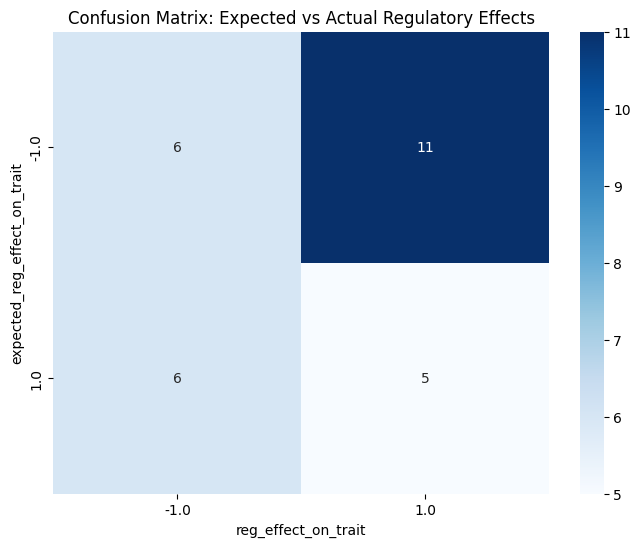

In [232]:
# Calculate expected and actual effects
DE_effects_merged['reg_effect_on_trait'] = -np.sign(DE_effects_merged['post_mean'])
DE_effects_merged['reg_effect_on_core'] = -DE_effects_merged['zscore_x']
DE_effects_merged['core_effect_on_trait'] = np.sign(DE_effects_merged['zscore_y'])
DE_effects_merged['expected_reg_effect_on_trait'] = DE_effects_merged['reg_effect_on_core'] * DE_effects_merged['core_effect_on_trait']


measured_total_effect = np.sign(DE_effects_merged.groupby('target_contrast_gene_name')['expected_reg_effect_on_trait'].sum())
genetic_total_effect = DE_effects_merged.groupby('target_contrast_gene_name')['reg_effect_on_trait'].first()


# Create confusion matrix
confusion = pd.crosstab(measured_total_effect, 
                       genetic_total_effect,
                       margins=False)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Expected vs Actual Regulatory Effects')


In [199]:
np.sign(reg_effect['post_mean'].iloc[0]) == np.sign(sum( reg_effect['zscore_x'] * reg_effect['zscore_y'] ))

np.True_

np.float64(1.0)

In [154]:
LC_regulators_effects = get_DE_results_long(adata_de, targets = LC_regulators, gene_id_col='gene_ids', target_id_col='target_contrast', target_metadata_cols=['target_contrast_gene_name', 'culture_condition'])
DE_frac_effects = res_df.reset_index().rename({'index':'gene_ids'}, axis=1)[['gene_ids','zscore']]
LC_regulators_effects = pd.merge(LC_regulators_effects, DE_frac_effects, left_on='gene_ids', right_on='gene_ids', how='left')

from scipy import stats

def corr_with_pval(x):
    # Drop rows where either zscore is NA
    valid_data = x.dropna(subset=['zscore_x', 'zscore_y'])
    if len(valid_data) < 2:  # Need at least 2 points for correlation
        return pd.Series({'correlation': np.nan, 'p_value': np.nan})
    r, p = stats.pearsonr(valid_data['zscore_x'], valid_data['zscore_y'])
    return pd.Series({'correlation': r, 'p_value': p})

correlations = LC_regulators_effects.groupby('target_contrast_gene_name').apply(corr_with_pval)
correlations = correlations.sort_values('correlation')

# Display correlations and p-values between DE effect sizes and target gene effects
correlations

/tmp/ipykernel_1829785/1488757111.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = LC_regulators_effects.groupby('target_contrast_gene_name').apply(corr_with_pval)


,correlation,p_value
target_contrast_gene_name,,
LTF,-0.060077,7.818710e-31
PHF3,-0.049659,1.430199e-21
SYNE2,-0.045593,1.965809e-18
DOP1B,-0.034031,6.360083e-11
ADAMTS17,-0.033081,2.118206e-10
...,...,...
ZSWIM7,0.040470,7.466908e-15
POLG2,0.041386,1.854489e-15
NABP1,0.044754,8.188417e-18


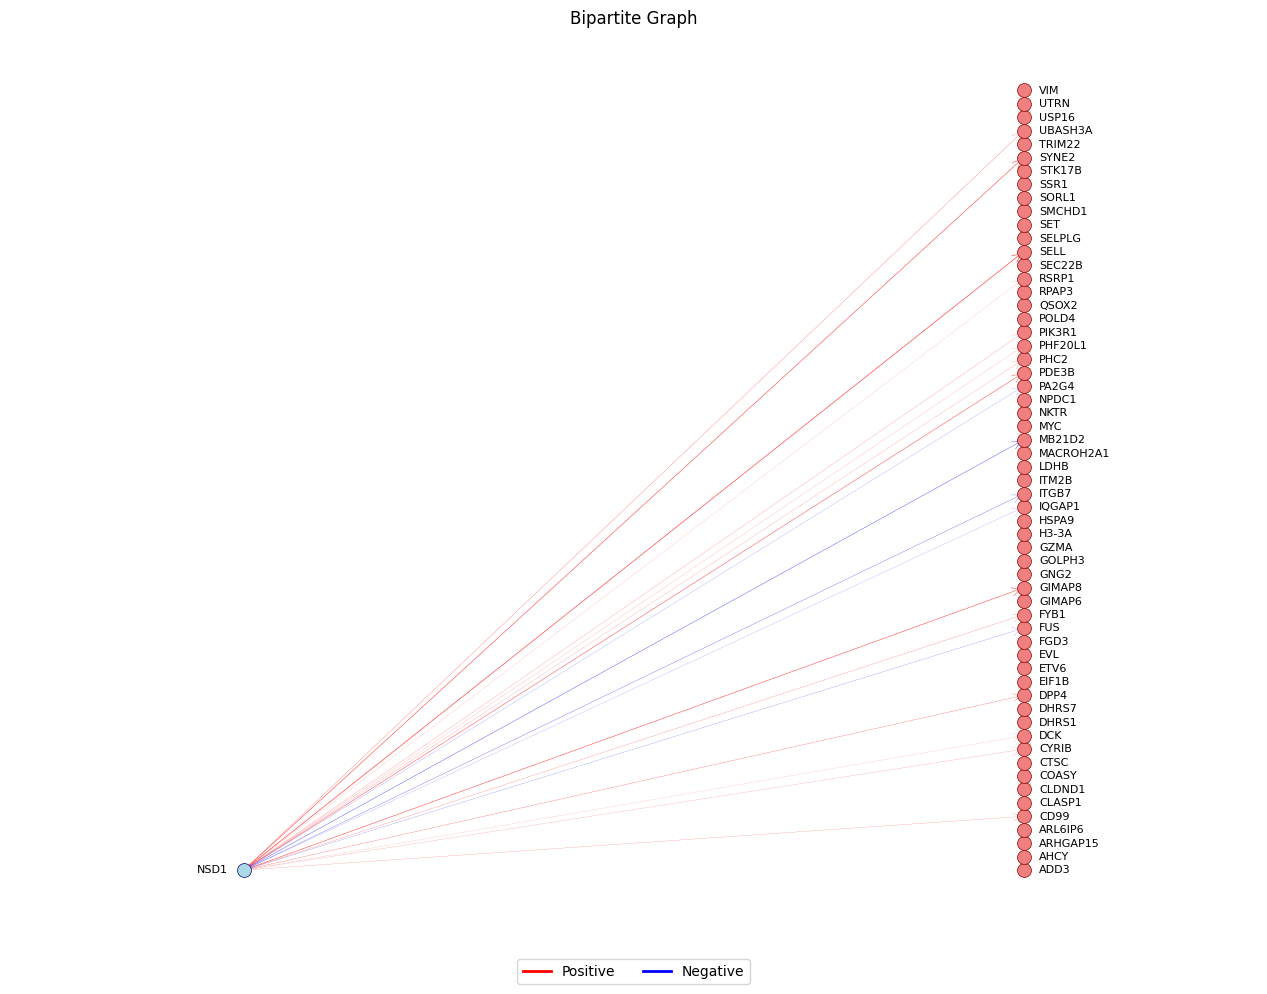

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import FancyArrowPatch
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def cluster_genes_by_interactions(df, method='hierarchical', n_clusters=None):
    """
    Cluster genes based on their interaction patterns
    
    Parameters:
    - df: DataFrame with interactions
    - method: 'hierarchical', 'kmeans', or 'correlation'
    - n_clusters: number of clusters (auto-determined if None)
    
    Returns:
    - left_order: ordered indices for left genes (rows)
    - right_order: ordered indices for right genes (columns)
    - left_clusters: cluster assignments for left genes
    - right_clusters: cluster assignments for right genes
    """
    
    if method == 'hierarchical':
        # Hierarchical clustering based on interaction patterns
        
        # Cluster left genes (rows) based on their outgoing connections
        left_linkage = linkage(pdist(df.values, metric='euclidean'), method='ward')
        if n_clusters is None:
            n_clusters_left = min(max(2, len(df.index) // 3), 6)
        else:
            n_clusters_left = n_clusters
        left_clusters = fcluster(left_linkage, n_clusters_left, criterion='maxclust')
        left_order = np.argsort(left_clusters)
        
        # Cluster right genes (columns) based on their incoming connections  
        right_linkage = linkage(pdist(df.values.T, metric='euclidean'), method='ward')
        if n_clusters is None:
            n_clusters_right = min(max(2, len(df.columns) // 3), 6)
        else:
            n_clusters_right = n_clusters
        right_clusters = fcluster(right_linkage, n_clusters_right, criterion='maxclust')
        right_order = np.argsort(right_clusters)
        
    elif method == 'kmeans':
        # K-means clustering
        if n_clusters is None:
            n_clusters = min(max(2, len(df.index) // 4), 5)
        
        # Cluster left genes
        kmeans_left = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        left_clusters = kmeans_left.fit_predict(df.values)
        left_order = np.argsort(left_clusters)
        
        # Cluster right genes
        kmeans_right = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        right_clusters = kmeans_right.fit_predict(df.values.T)
        right_order = np.argsort(right_clusters)
        
    elif method == 'correlation':
        # Cluster based on correlation patterns
        
        # Left genes: cluster by correlation of their interaction profiles
        left_corr = np.corrcoef(df.values)
        left_corr_dist = 1 - np.abs(left_corr)  # Distance = 1 - |correlation|
        np.fill_diagonal(left_corr_dist, 0)
        
        left_linkage = linkage(pdist(left_corr_dist), method='average')
        if n_clusters is None:
            n_clusters_left = min(max(2, len(df.index) // 3), 6)
        else:
            n_clusters_left = n_clusters
        left_clusters = fcluster(left_linkage, n_clusters_left, criterion='maxclust')
        left_order = np.argsort(left_clusters)
        
        # Right genes: cluster by correlation of their interaction profiles
        right_corr = np.corrcoef(df.values.T)
        right_corr_dist = 1 - np.abs(right_corr)
        np.fill_diagonal(right_corr_dist, 0)
        
        right_linkage = linkage(pdist(right_corr_dist), method='average')
        if n_clusters is None:
            n_clusters_right = min(max(2, len(df.columns) // 3), 6)
        else:
            n_clusters_right = n_clusters
        right_clusters = fcluster(right_linkage, n_clusters_right, criterion='maxclust')
        right_order = np.argsort(right_clusters)
    
    return left_order, right_order, left_clusters[left_order], right_clusters[right_order]


def create_bipartite_graph_clustered(df, method='hierarchical', n_clusters=None, 
                                    figsize=(12, 8), arrow_width_scale=1.0, alpha=0.7,
                                    show_clusters=False):
    """
    Create a bipartite graph with optional gene clustering by interaction patterns
    """
    
    if show_clusters:
        # Get clustering order if clustering is enabled
        left_order, right_order, left_cluster_labels, right_cluster_labels = cluster_genes_by_interactions(
            df, method=method, n_clusters=n_clusters)
        
        # Reorder genes based on clustering
        y_genes = [df.index[i] for i in left_order]
        x_genes = [df.columns[i] for i in right_order]
    else:
        # Use original order if no clustering
        y_genes = df.index.tolist()
        x_genes = df.columns.tolist()
        left_cluster_labels = [1] * len(y_genes)  # Single cluster
        right_cluster_labels = [1] * len(x_genes)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Position nodes
    left_x = 0
    right_x = 1
    
    # Y positions with potential gaps between clusters if show_clusters=True
    if show_clusters:
        left_positions = {}
        right_positions = {}
        
        # Left side clustering
        left_y_pos = 0
        current_cluster = left_cluster_labels[0]
        cluster_colors_left = plt.cm.Set3(np.linspace(0, 1, len(np.unique(left_cluster_labels))))
        
        for i, (gene, cluster) in enumerate(zip(y_genes, left_cluster_labels)):
            if cluster != current_cluster:
                left_y_pos += 0.05  # Add gap between clusters
                current_cluster = cluster
            left_positions[gene] = (left_x, left_y_pos)
            left_y_pos += 1.0 / (len(y_genes) + 0.05 * len(np.unique(left_cluster_labels)))
        
        # Normalize left positions
        max_y = max(pos[1] for pos in left_positions.values())
        left_positions = {gene: (pos[0], pos[1]/max_y) for gene, pos in left_positions.items()}
        
        # Right side clustering  
        right_y_pos = 0
        current_cluster = right_cluster_labels[0]
        cluster_colors_right = plt.cm.Set2(np.linspace(0, 1, len(np.unique(right_cluster_labels))))
        
        for i, (gene, cluster) in enumerate(zip(x_genes, right_cluster_labels)):
            if cluster != current_cluster:
                right_y_pos += 0.05
                current_cluster = cluster
            right_positions[gene] = (right_x, right_y_pos)
            right_y_pos += 1.0 / (len(x_genes) + 0.05 * len(np.unique(right_cluster_labels)))
        
        # Normalize right positions
        max_y = max(pos[1] for pos in right_positions.values())
        right_positions = {gene: (pos[0], pos[1]/max_y) for gene, pos in right_positions.items()}
        
    else:
        # Simple equidistant positioning
        left_y_positions = np.linspace(0, 1, len(y_genes))
        left_positions = {gene: (left_x, y_pos) for gene, y_pos in zip(y_genes, left_y_positions)}
        
        right_y_positions = np.linspace(0, 1, len(x_genes))
        right_positions = {gene: (right_x, y_pos) for gene, y_pos in zip(x_genes, right_y_positions)}
    
    # Draw nodes with cluster colors
    for i, (gene, cluster) in enumerate(zip(y_genes, left_cluster_labels)):
        x, y = left_positions[gene]
        if show_clusters:
            color = cluster_colors_left[cluster - 1]  # clusters are 1-indexed
        else:
            color = 'lightblue'
        ax.scatter(x, y, c=[color], s=100, zorder=3, edgecolor='navy', linewidth=0.5)
        ax.text(x-0.02, y, gene, ha='right', va='center', fontsize=8)
    
    for i, (gene, cluster) in enumerate(zip(x_genes, right_cluster_labels)):
        x, y = right_positions[gene]
        if show_clusters:
            color = cluster_colors_right[cluster - 1]
        else:
            color = 'lightcoral'
        ax.scatter(x, y, c=[color], s=100, zorder=3, edgecolor='darkred', linewidth=0.5)
        ax.text(x+0.02, y, gene, ha='left', va='center', fontsize=8)
    
    # Draw arrows for non-zero values
    arrows_pos = []
    arrows_neg = []
    
    for y_gene in y_genes:
        for x_gene in x_genes:
            value = df.loc[y_gene, x_gene]
            
            if value != 0:
                start_pos = left_positions[y_gene]
                end_pos = right_positions[x_gene]
                
                arrow_width = min(abs(value) * arrow_width_scale, 3)
                
                if value > 0:
                    arrows_pos.append((start_pos, end_pos, arrow_width))
                else:
                    arrows_neg.append((start_pos, end_pos, arrow_width))
    
    # Draw positive arrows (red)
    for start, end, width in arrows_pos:
        arrow = FancyArrowPatch(start, end, 
                               arrowstyle='->', 
                               color='red', 
                               alpha=alpha,
                               linewidth=width,
                               mutation_scale=15)
        ax.add_patch(arrow)
    
    # Draw negative arrows (blue)  
    for start, end, width in arrows_neg:
        arrow = FancyArrowPatch(start, end,
                               arrowstyle='->',
                               color='blue',
                               alpha=alpha, 
                               linewidth=width,
                               mutation_scale=15)
        ax.add_patch(arrow)
    
    # Formatting
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='red', lw=2, label='Positive'),
                      Line2D([0], [0], color='blue', lw=2, label='Negative')]
    
    if show_clusters:
        legend_elements.extend([
            Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
                  markersize=8, label='Y-gene clusters', linestyle='None'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray',
                  markersize=8, label='X-gene clusters', linestyle='None')
        ])
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
    
    title = 'Bipartite Graph'
    if show_clusters:
        title += f' ({method} clustering)\nGenes grouped by interaction patterns'
    plt.title(title, pad=20)
    plt.tight_layout()
    
    if show_clusters:
        return fig, ax, (left_order, right_order, left_cluster_labels, right_cluster_labels)
    else:
        return fig, ax, None

# Additional function to analyze clustering quality
def analyze_clusters(df, cluster_info):
    """Analyze the quality of gene clustering"""
    if cluster_info is None:
        print("No clustering information available - clustering was not performed")
        return df
        
    left_order, right_order, left_clusters, right_clusters = cluster_info
    
    # Reorder dataframe according to clustering
    df_reordered = df.iloc[left_order, :].iloc[:, right_order]
    
    # Calculate within-cluster vs between-cluster interaction strengths
    left_genes = [df.index[i] for i in left_order] 
    right_genes = [df.columns[i] for i in right_order]
    
    print("Cluster Analysis:")
    print(f"Left genes grouped into {len(np.unique(left_clusters))} clusters")
    print(f"Right genes grouped into {len(np.unique(right_clusters))} clusters")
    
    # Show genes in each cluster
    for cluster_id in np.unique(left_clusters):
        genes_in_cluster = [gene for gene, cluster in zip(left_genes, left_clusters) if cluster == cluster_id]
        print(f"Left Cluster {cluster_id}: {genes_in_cluster}")
    
    for cluster_id in np.unique(right_clusters):
        genes_in_cluster = [gene for gene, cluster in zip(right_genes, right_clusters) if cluster == cluster_id]
        print(f"Right Cluster {cluster_id}: {genes_in_cluster}")
    
    return df_reordered

# Usage:
fig, ax, cluster_info = create_bipartite_graph_clustered(
    pl_df[['NSD1']].T, method='kmeans', figsize=(15, 10), 
    arrow_width_scale=0.5, show_clusters=False
);

In [ ]:
pl_df[['NSD1']]

gene
ADD3         0.000000
AHCY         0.000000
ARHGAP15     0.000000
ARL6IP6      0.000000
CD99         0.279709
CLASP1       0.000000
CLDND1       0.000000
COASY        0.000000
CTSC         0.000000
CYRIB        0.243537
DCK          0.178694
DHRS1        0.000000
DHRS7        0.000000
DPP4         0.424436
EIF1B        0.000000
ETV6         0.000000
EVL          0.000000
FGD3         0.000000
FUS         -0.295007
FYB1         0.331767
GIMAP6       0.000000
GIMAP8       0.794268
GNG2         0.000000
GOLPH3       0.000000
GZMA         0.000000
H3-3A        0.000000
HSPA9        0.000000
IQGAP1      -0.233910
ITGB7       -0.470152
ITM2B        0.000000
LDHB         0.000000
MACROH2A1    0.000000
MB21D2      -0.631299
MYC          0.000000
NKTR         0.000000
NPDC1        0.000000
PA2G4       -0.260586
PDE3B        0.727691
PHC2         0.265196
PHF20L1      0.223889
PIK3R1       0.299801
POLD4        0.000000
QSOX2        0.000000
RPAP3        0.000000
RSRP1        0.183646
SEC22

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, -4.0, '−4'),
  Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6')])

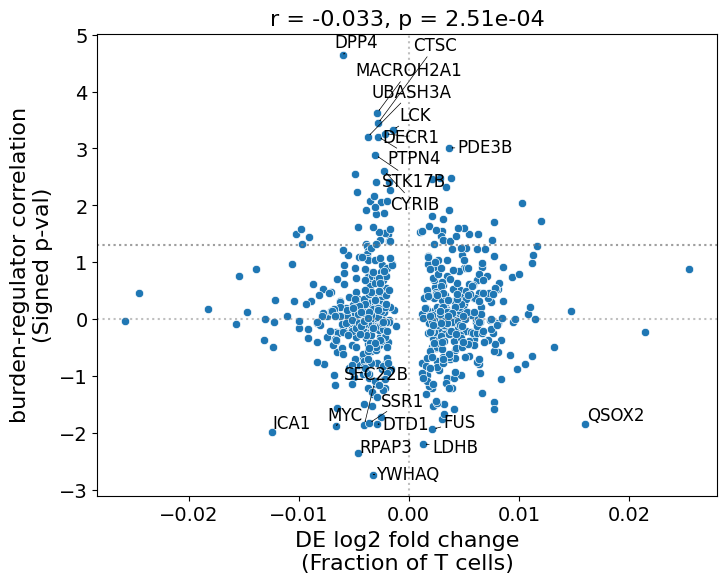

In [ ]:
# Merge DE and LoF results
de_results_signif = res_df.dropna().rename({'variable':'ensg'}, axis=1)[['ensg', 'adj_p_value', 'log_fc', 'gene_name']]
lof_results_signif = lof_results[['ensg', 'P_withShet', 'beta_withShet']]

merged_df = pd.merge(de_results_signif[['ensg', 'log_fc', 'adj_p_value', 'gene_name']], 
                    lof_results_signif[['ensg', 'P_withShet', 'beta_withShet']], 
                    on='ensg', how='inner')
merged_df['signed_P_withShet'] = -np.log10(merged_df['P_withShet']) * np.sign(merged_df['beta_withShet'])

# Calculate correlation coefficient and p-value
from scipy import stats
r, p = stats.pearsonr(merged_df['log_fc'], merged_df['signed_P_withShet'])

# Create scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df[merged_df['adj_p_value'] < 0.1], x='log_fc', y='signed_P_withShet')

# Add horizontal dotted lines at y=0, 1, and -1
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-np.log10(0.05), color='gray', linestyle=':', alpha=0.5)

# Get top genes by absolute log fold change
top_genes = merged_df[merged_df['adj_p_value'] < 0.1].nlargest(10, 'signed_P_withShet')
bot_genes = merged_df[merged_df['adj_p_value'] < 0.1].nsmallest(10, 'signed_P_withShet')
top_genes = pd.concat([top_genes, bot_genes])

# Add gene labels with adjustText to avoid overlap
from adjustText import adjust_text

texts = []
for _, gene in top_genes.iterrows():
    texts.append(plt.text(gene['log_fc'], gene['signed_P_withShet'], 
                         gene['gene_name'], fontsize=12))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.xlabel('DE log2 fold change\n(Fraction of T cells)', fontsize=16)
plt.ylabel('burden-regulator correlation\n(Signed p-val)', fontsize=16)
plt.title(f'r = {r:.3f}, p = {p:.2e}', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
de_gs = de_results_signif[de_results_signif['adj_p_value'] < 0.1].ensg.unique()
lof_results['DE_gene'] = lof_results['ensg'].isin(de_gs)
lof_results.sort_values("P_withShet")[0:50]

,gene,ensg,P_withShet,beta_withShet,betaSE_withShet,P_pearson,R_pearson,R_pearson_CIlower,R_pearson_CIupper,DE_gene
3469,IL18R1,ENSG00000115604,7.218351e-07,0.047610,0.009602,0.000004,0.044622,0.025712,0.063500,False
9257,ITGAM,ENSG00000169896,3.728092e-06,0.044474,0.009609,0.000038,0.039805,0.020890,0.058692,False
8369,SAMD3,ENSG00000164483,5.854221e-06,0.043531,0.009601,0.000016,0.041703,0.022790,0.060587,False
12446,FAM237A,ENSG00000235118,1.043929e-05,0.370215,0.080851,0.000008,0.369077,0.215840,0.504571,False
9709,CYSLTR1,ENSG00000173198,1.302260e-05,0.041888,0.009603,0.000048,0.039270,0.020354,0.058158,False
139,SLC13A2,ENSG00000007216,1.967830e-05,-0.216696,0.050125,0.000027,-0.212567,-0.306250,-0.114806,False
11644,DPP4,ENSG00000197635,2.231702e-05,0.040764,0.009609,0.000160,0.036447,0.017528,0.055340,True
3756,VAMP8,ENSG00000118640,3.789648e-05,0.039586,0.009604,0.000013,0.042119,0.023206,0.061001,False
5310,BIVM,ENSG00000134897,5.828683e-05,0.038614,0.009602,0.000108,0.037381,0.018463,0.056272,False
8772,STX3,ENSG00000166900,9.938451e-05,0.037399,0.009605,0.000324,0.034717,0.015796,0.053613,False
